<a href="https://colab.research.google.com/github/PMDixit/handGesture/blob/main/IndianFinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install opendatasets --quiet

In [ ]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, SubsetRandomSampler
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt
import opendatasets as od
%matplotlib inline
import cv2
import numpy as np
from PIL import Image
from google.colab.patches import cv2_imshow

matplotlib.rcParams['figure.facecolor'] = '#ffffff'#to keep background white

In [ ]:
project_name='indian-sign-language'

In [ ]:
#downloading dataset
dataset_url="https://www.kaggle.com/datasets/satwikpasumarthi/indian-sign-language-recognition"
#prajwalmdixit
#6960242e59b78799065573dee90d4200
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: prajwalmdixit
Your Kaggle Key: ··········


100%|██████████| 33.9M/33.9M [00:00<00:00, 64.1MB/s]


In [ ]:
# Look into the data directory
data_dir = '/content/indian-sign-language-recognition/data1/train/'
classes = os.listdir(data_dir)
print(classes)

['L', 'T', 'Z', '2', 'A', 'O', 'G', '8', '0', 'I', 'J', 'K', 'W', 'Y', 'E', 'V', 'D', 'C', '7', 'X', 'R', 'Q', '3', '5', 'N', 'B', 'U', '9', 'P', '6', '1', '4', 'F', 'S', 'H', 'M']


In [ ]:
#for indian combining both the test and train images to train folder
for i in classes:
    IMAGE_FILES = os.listdir("/content/indian-sign-language-recognition/data1/test/"+i)
    for idx, file in enumerate(IMAGE_FILES):
      img=cv2.imread("/content/indian-sign-language-recognition/data1/test/"+i+"/"+file)
      cv2.imwrite('/content/indian-sign-language-recognition/data1/train/'+i+"/"+ str(idx+60)+'.jpg', img)

In [ ]:
#listing 5 images of label A
A_file=os.listdir(data_dir+"A")
print("NO. of Training examples for A:",len(A_file))
print(A_file[:5])

NO. of Training examples for A: 70
['0.jpg', '13.jpg', '22.jpg', '32.jpg', '34.jpg']


In [ ]:
#listing the images for every label
di={}
for i in classes:
    di[i]=len(os.listdir(data_dir+i))
print(di)

{'L': 71, 'T': 70, 'Z': 70, '2': 70, 'A': 70, 'O': 70, 'G': 70, '8': 71, '0': 70, 'I': 70, 'J': 71, 'K': 70, 'W': 56, 'Y': 73, 'E': 70, 'V': 70, 'D': 72, 'C': 69, '7': 70, 'X': 70, 'R': 71, 'Q': 63, '3': 70, '5': 71, 'N': 70, 'B': 70, 'U': 72, '9': 73, 'P': 74, '6': 70, '1': 70, '4': 71, 'F': 72, 'S': 70, 'H': 70, 'M': 70}


In [ ]:
target_num = len(classes)
target_num

36

In [ ]:
#image preprocessing same as in vscode(application)
import shutil
minValue=50
#shutil.rmtree("/content/segmentedImage/")
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2,2))
#for every class (36 classes)
for i in classes:
    #creating dir for every class
    os.makedirs("/content/segmentedImage/"+i,exist_ok=True)
    IMAGE_FILES = os.listdir(data_dir+i)[:1500]
    #for every image for the selected class(label)
    for idx, file in enumerate(IMAGE_FILES):
      img=cv2.imread(data_dir+i+"/"+file)
      #grayscale
      gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
      #gussianblur
      blur = cv2.GaussianBlur(gray,(5,5),2)
      #thresolding
      th3 = cv2.adaptiveThreshold(blur,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY_INV,11,2)
      ret, res = cv2.threshold(th3, minValue, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
      #morphological operations
      res = cv2.morphologyEx(res, cv2.MORPH_CLOSE, kernel)
      #saving preprocessed image
      cv2.imwrite('/content/segmentedImage/'+i+"/"+ str(idx)+'.jpg', res)


In [ ]:
#changing data dir to preprocessed classes
data_dir="/content/segmentedImage/"

In [ ]:
#function to show images in grid
def show_batch(dl):
    for images, labels in dl:
      fig, ax = plt.subplots(figsize=(12, 12))
      ax.set_xticks([]); ax.set_yticks([])
      plt.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0))
      break

Dimension: torch.Size([3, 261, 310])


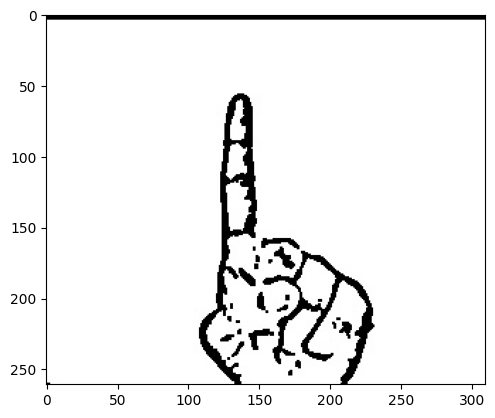

In [ ]:
#code to show an preprocessed image
raw_images = ImageFolder(data_dir, tt.ToTensor())
image, label = raw_images[89]
print("Dimension:", image.shape)
plt.imshow(image.permute(1, 2, 0))

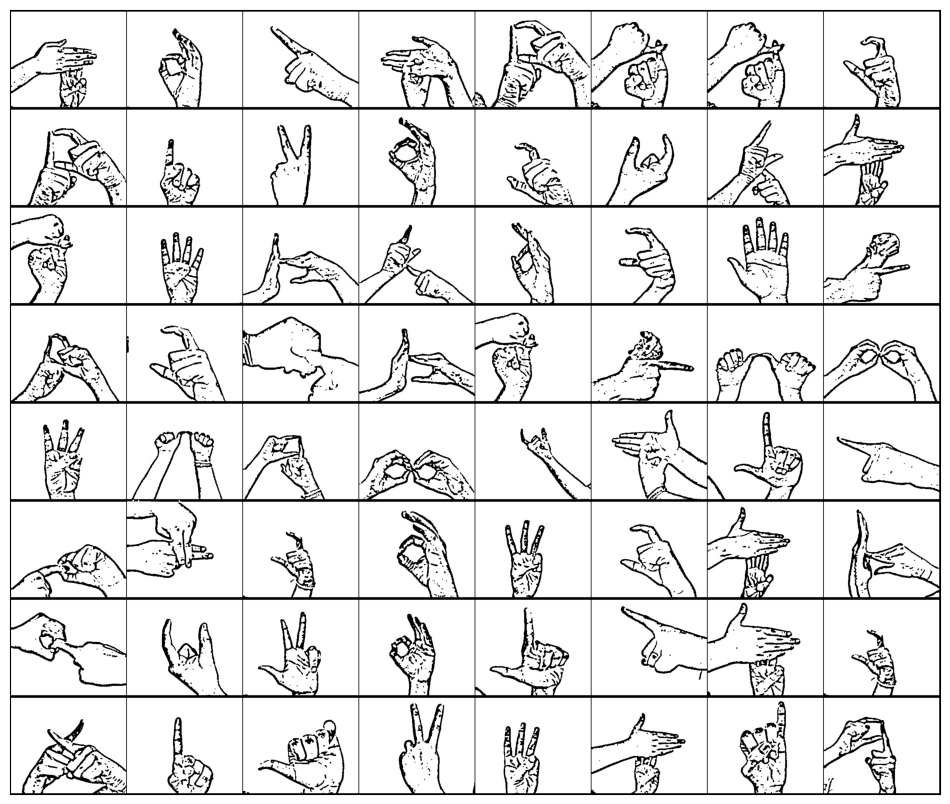

In [ ]:
# code just show preprocces images in grid
raw_dl = DataLoader(raw_images, 100, shuffle=True, num_workers=2, pin_memory=True)
show_batch(raw_dl)

In [ ]:
#defining the image resize and torch conversion
train_tfms = tt.Compose([ tt.ToTensor() , tt.Resize(size = (128,128))])

valid_tfms = tt.Compose([tt.ToTensor(), tt.Resize(size = (128,128))])

In [ ]:
#applieng the above conversion for actual pre processed images
train_data = ImageFolder(data_dir, transform=train_tfms)
valid_data = ImageFolder(data_dir, transform=valid_tfms)
test_data = ImageFolder(data_dir, transform=valid_tfms)
#just showing the shape after resize
img,label=train_data[0]
img.shape

torch.Size([3, 128, 128])

In [ ]:
#splitting data to test train validation data
num_train = len(train_data)
indices = list(range(num_train))
# We'll fix the random state to avoid change in the creation of train and valid data.
np.random.seed(42)
np.random.shuffle(indices)
# Let's take 15% of the train data as validation and 10% as test
valid_size = 0.15 #15%
test_size = 0.10  #10%
#rest for training (75%)
val_split = int(np.floor(valid_size * num_train))
test_split = int(np.floor(test_size * num_train))
                                 #from 0 to val_split=validation data , from val_split to test_split=test data , rest for training
valid_idx, test_idx, train_idx = indices[:val_split], indices[val_split:val_split+test_split], indices[val_split+test_split:]

In [ ]:
#batch size defines the how much images sholud go to memory once
batch_size = 100

In [ ]:
# define samplers for obtaining training and validation batches(which creates suffule in data)
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (Dataloder loades the data into memory)
train_dl = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=2, pin_memory=True)
valid_dl = torch.utils.data.DataLoader(valid_data, batch_size=batch_size,
    sampler=valid_sampler, num_workers=2, pin_memory=True)

In [ ]:
#for computing check
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

#for dataloader
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)
#Device Dataloder bindes the batched to cpu or gpu based on availability
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

In [ ]:
import torchvision.models as models
#defining the mobilenetv2 model and finetuning it
model_ft = models.mobilenet_v2(pretrained=False)
in_features = model_ft._modules['classifier'][-1].in_features
model_ft._modules['classifier'][-1] = nn.Linear(in_features, target_num, bias=True)
model_ft = model_ft.to(device)
model=model_ft
print(model)

#finding accuracy of a batch
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

#for training and testing funtions
class mobilenet_V2:
    def training_step(model, batch):
        images, labels = batch
        out = model(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss

    def validation_step(model, batch):
        images, labels = batch
        out = model(images)                   # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(model, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(model, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [mobilenet_V2.validation_step(model,batch) for batch in val_loader]
    return mobilenet_V2.validation_epoch_end(model,outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

#training cycle
def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader,
                  weight_decay=0, grad_clip=None, opt_func):
    torch.cuda.empty_cache()
    history = []

    # Set up custom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs,
                                                steps_per_epoch=len(train_loader))

    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = mobilenet_V2.training_step(model,batch)
            train_losses.append(loss)
            loss.backward()

            # Gradient clipping
            if grad_clip:
              nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()

        # Validation phase
        result = evaluate(model, val_loader) #which will call validation_step
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        mobilenet_V2.epoch_end(model,epoch, result)
        history.append(result)
    return history

In [ ]:
history = [evaluate(model, valid_dl)]
history

[{'val_loss': 3.584275245666504, 'val_acc': 0.02320512756705284}]

In [ ]:
epochs = 8
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [ ]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl,
                             grad_clip=grad_clip,
                             weight_decay=weight_decay,
                             opt_func=opt_func)
train_time='10:00'

Epoch [0], last_lr: 0.00377, train_loss: 3.4356, val_loss: 4.2313, val_acc: 0.0285
Epoch [1], last_lr: 0.00933, train_loss: 2.2286, val_loss: 6.9726, val_acc: 0.0303
Epoch [2], last_lr: 0.00972, train_loss: 1.1740, val_loss: 10.6982, val_acc: 0.0724
Epoch [3], last_lr: 0.00812, train_loss: 0.5977, val_loss: 8.6216, val_acc: 0.0653
Epoch [4], last_lr: 0.00556, train_loss: 0.2557, val_loss: 2.3657, val_acc: 0.4304
Epoch [5], last_lr: 0.00283, train_loss: 0.1078, val_loss: 0.4081, val_acc: 0.8622
Epoch [6], last_lr: 0.00077, train_loss: 0.0435, val_loss: 0.0881, val_acc: 0.9800
Epoch [7], last_lr: 0.00000, train_loss: 0.0188, val_loss: 0.0349, val_acc: 0.9925
CPU times: user 7.55 s, sys: 2.44 s, total: 10 s
Wall time: 40.3 s


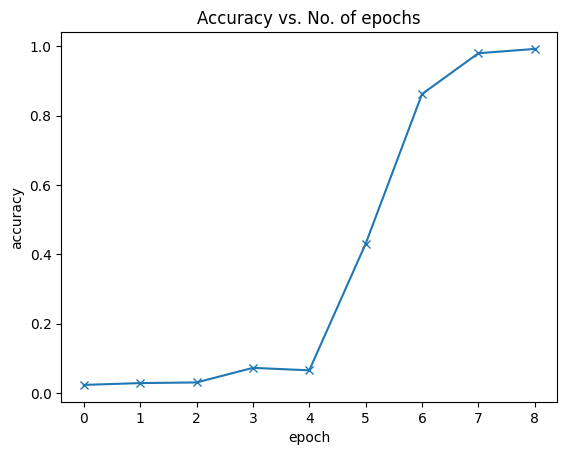

In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');
plot_accuracies(history)

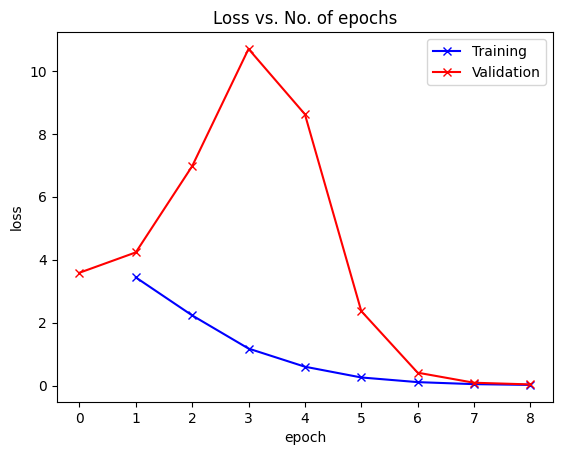

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');
plot_losses(history)

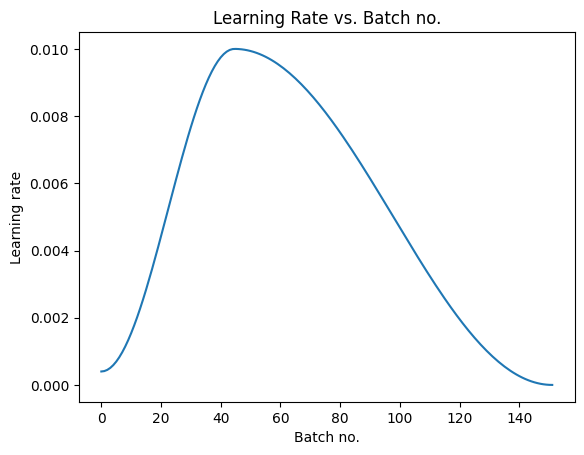

In [ ]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');
plot_lrs(history)

In [ ]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb).squeeze(0).softmax(0)
    # Pick index with highest probability
    preds  = yb.argmax().item()
    # Retrieve the class label
    return train_data.classes[preds]

In [ ]:
correct = []
for i in test_idx:
    img, lab = test_data[i]
    xb = to_device(img.unsqueeze(0), device)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    correct.append(preds[0].item() == lab)
print(f"Accuracy [Test Data]: {sum(correct) / len(test_idx) * 100} %")

Accuracy [Test Data]: 99.60317460317461 %


In [ ]:
from sklearn.metrics import confusion_matrix
ytrue=[]
ypred=[]
for i in test_idx:
    img, label = test_data[i]
    ytrue.append(test_data.classes[label])
    ypred.append(predict_image(img, model))
confusion_matrix(ytrue,ypred)

array([[6, 0, 0, ..., 0, 0, 0],
       [0, 9, 0, ..., 0, 0, 0],
       [0, 0, 7, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 7, 0, 0],
       [0, 0, 0, ..., 0, 8, 0],
       [0, 0, 0, ..., 0, 0, 8]])

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


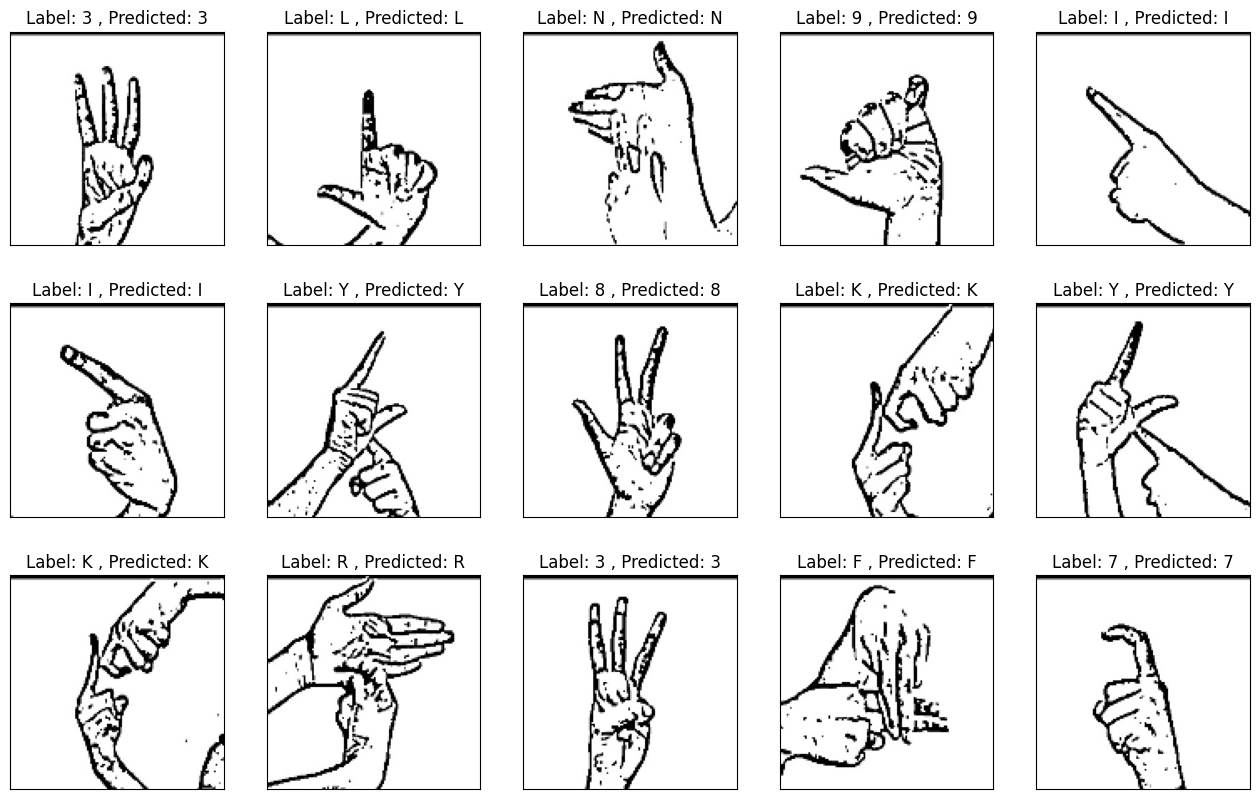

In [ ]:
n_rows, n_cols, i = 3, 5, 1
fig = plt.figure(figsize=(16,10))
for index in test_idx[:15]:
    img, label = test_data[index]
    ax = fig.add_subplot(n_rows, n_cols, i)
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(img.permute(1, 2, 0).clamp(0,1))
    ax.set_title(f"Label: {test_data.classes[label]} , Predicted: {predict_image(img, model)}")
    i+=1

In [ ]:
#saving the model
import joblib
torch.save(model.state_dict(), '/content/MobileNet_V2ASLNotEroded.pth')
filename = 'ISN-1-custom-resnet.sav'
joblib.dump(model, filename)


['ISN-1-custom-resnet.sav']